In [1]:
import argparse, pydicom
import torch
import numpy as np

from pathlib import Path
from typing import Any, Dict, Iterable, Tuple, List
from omegaconf import DictConfig, OmegaConf

import tg43.dicom_helper as dhelp
import tg43.contour_helper as chelp
import tg43.dose_calculation as dosecal
import tg43.utils as utils

In [2]:
def load_hyperparams(config_path: Path) -> Tuple[DictConfig, Dict]:
    """Load MCO-IPSA hyperparameters from YAML and resolve runtime types."""

    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)  # type: ignore[arg-type]
    hyperparams = cfg_dict["hyperparams"]
    hyperparams["anisotropy_table"] = Path(hyperparams["anisotropy_table"])
    hyperparams["radial_table"] = Path(hyperparams["radial_table"])
    return cfg, hyperparams

def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first path from ``path_iterable`` or raise if empty."""

    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]

def load_case_paths(root: Path, case_id: int) -> Dict[str, Path]:
    """Collect CT, RTDOSE, RTPLAN, and RTSTRUCT paths for a case."""

    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [3]:
cfg, hyperparams = load_hyperparams(Path("config.yaml"))
cfg, hyperparams

({'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx'}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}},
 {'anisotropy_table': PosixPath('ESTRO/nucletron_mhdr-v2_F.xlsx'),
  'radial_table': PosixPath('ESTRO/nucletron_mhdr-v2_gL.xlsx')})

In [4]:
data_root = Path(cfg['run']['data-root'])
case_id = Path(cfg['run']['case'])
print(f"Data root: {data_root}")
print(f"Case ID: {case_id}")
paths = load_case_paths(data_root, case_id)
paths

Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case6


{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'),
 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'),
 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_0_20240112/series_1_1.3.6.1.4.1.2452.6.1356188019.1134003628.1522809736.1180775174/ima_empty_uid_1.3.6.1.4.1.2452.6.3162210145.1093853173.1113596587.2422958571.dcm'),
 'struct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTSTRUCT_0_20240112/series_1_1.3.6.1.4.1.2452.6.3775943779.1152257382.1983088276.1409971453/ima_empty_uid_1.3.6.1.4.1.2452.6.3039571248.1233624635.2885846168.1640366842.dcm')}

In [5]:
# CT
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths["ct"])

# RTDOSE
dose_image, dose_array, dose_metadata = dhelp.load_rtdose_volume(paths['dose'])
dose_image_r, dose_array_r, dose_metadata_r = dhelp.resample_to_reference(dose_image, ct_image)

# RTPLAN
rt_channels = dhelp.load_rtplan_by_channel(paths["plan"])

# RTSTRUCT
rtstruct = chelp.load_rtstruct(paths["struct"])

In [6]:
rt_channels

[ChannelInfo(setup_number=0, channel_number=1, channel_id='Channel_1', total_time_s=33.1780900468977, final_cumulative_weight=0.73333310879436, positions_cm=[array([  0.5379861, -13.3453959,  47.7999833]), array([  0.5379861, -13.3453959,  47.7999833]), array([  0.5523497, -13.8179753,  47.6373107]), array([  0.5523497, -13.8179753,  47.6373107]), array([  0.5643543, -14.2816131,  47.4528961]), array([  0.5643543, -14.2816131,  47.4528961]), array([  0.5593393, -14.6576535,  47.1279034]), array([  0.5593393, -14.6576535,  47.1279034])], cumulative_weights=array([0.        , 0.18333328, 0.18333328, 0.36666655, 0.36666655,
        0.54999983, 0.54999983, 0.73333311]), relative_positions=array([ 0.,  0.,  5.,  5., 10., 10., 15., 15.]), strengths_U=array([40688.78106796, 40688.78106796, 40688.78106796, 40688.78106796,
        40688.78106796, 40688.78106796, 40688.78106796, 40688.78106796])),
 ChannelInfo(setup_number=0, channel_number=2, channel_id='Channel_2', total_time_s=33.178090046897

In [7]:
rt_channels[0].positions_cm

[array([  0.5379861, -13.3453959,  47.7999833]),
 array([  0.5379861, -13.3453959,  47.7999833]),
 array([  0.5523497, -13.8179753,  47.6373107]),
 array([  0.5523497, -13.8179753,  47.6373107]),
 array([  0.5643543, -14.2816131,  47.4528961]),
 array([  0.5643543, -14.2816131,  47.4528961]),
 array([  0.5593393, -14.6576535,  47.1279034]),
 array([  0.5593393, -14.6576535,  47.1279034])]

In [8]:
import importlib
importlib.reload(dhelp)

dwell_positions = dhelp.extract_dwell_positions(ct_image, rt_channels)
dwell_positions.shape, dwell_positions

((19, 3),
 array([[281.91070995, 247.21326763,  82.5956605 ],
        [262.47945414, 245.83367374,  83.0144805 ],
        [276.40080216, 233.00671459, 104.2883515 ],
        [281.53330412, 252.93206029,  83.522363  ],
        [282.14131154, 242.58159072,  80.9643805 ],
        [262.15335467, 257.41201206,  84.7499165 ],
        [274.46450226, 240.98259988,  94.854956  ],
        [273.49635231, 244.97054315,  90.138258  ],
        [274.94857724, 238.98862825,  97.2133045 ],
        [262.41743289, 241.1831258 ,  81.389517  ],
        [275.91672719, 235.00068622, 101.9300025 ],
        [273.01227733, 246.96451355,  87.779909  ],
        [277.85302833, 227.02480093, 111.363398  ],
        [281.13773217, 258.76210412,  84.340075  ],
        [277.36895335, 229.01877132, 109.005049  ],
        [262.33099146, 251.56755185,  83.9365535 ],
        [276.88487714, 231.01274296, 106.6467    ],
        [273.98042729, 242.97657152,  92.496607  ],
        [275.43265221, 236.99465786,  99.5716535 ]]))

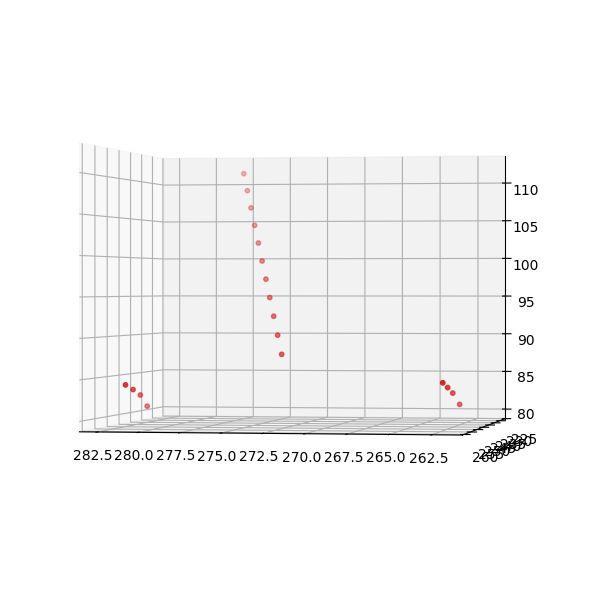

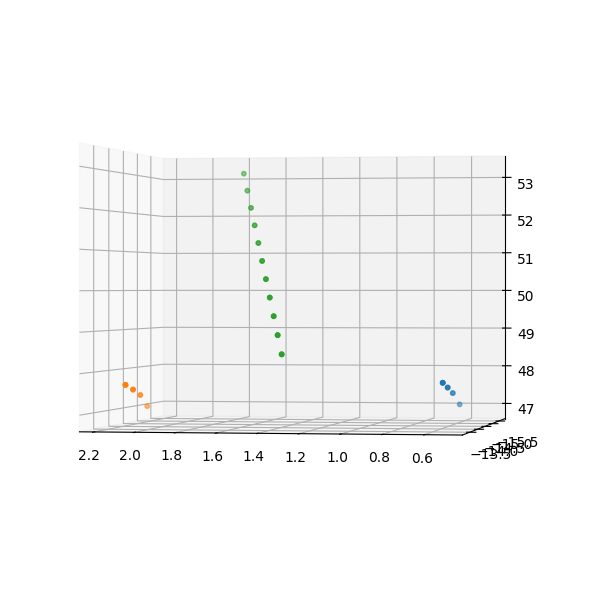

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dwell_positions[:, 0], dwell_positions[:, 1], dwell_positions[:, 2], c='tab:red', s=10)

ax.view_init(elev=0, azim=100, roll=0)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

for channel in rt_channels:
    positions = np.array(channel.positions_cm)
    if positions is not None:
        ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=10)

ax.view_init(elev=0, azim=100, roll=0)
plt.tight_layout()
plt.show()

[281.91070995 247.21326763  82.5956605 ]
276.0
159
[slice(None, None, None), slice(None, None, None), slice(None, None, None)]
! [102, slice(None, None, None), slice(None, None, None)]
[281.91070995 247.21326763  82.5956605 ] 102 (512, 512)


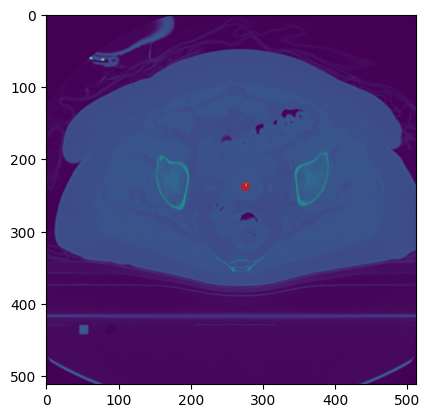

In [10]:
def get_slice_for_dwell(ct_array: np.ndarray, dwell_position: np.ndarray, axis: int = 0):
    print(dwell_positions[axis])
    print(np.round(dwell_position[axis]))
    print(ct_array.shape[axis] - 1)
    rounded = int(np.clip(np.round(dwell_position[-1+axis]), 0, ct_array.shape[axis] - 1))
    slicer = [slice(None)] * 3
    print(slicer)
    slicer[axis] = rounded
    print("!", slicer)
    return rounded, ct_array[tuple(slicer)]

dwell_index = 10
slice_idx, slice_data = get_slice_for_dwell(ct_array, dwell_positions[dwell_index], axis=0)
print(dwell_positions[0], slice_idx, slice_data.shape)

plt.imshow(slice_data)
plt.scatter(dwell_positions[-1][0], dwell_positions[-1][1], color='red', alpha=0.5)

In [11]:
structures = ["Bladder", "Rectum", "Sigmoid", "Bowel", "HR-CTV"]

num_axial, num_coronal, num_sagittal = ct_array.shape
num_class = len(structures)
mask_holder = np.zeros((num_axial, num_coronal, num_sagittal, num_class))
for idx_structure, name_structure in enumerate(structures):
    mask_tmp = chelp.rasterise_structure(rtstruct, name_structure, ct_image)
    print(mask_tmp.shape)
    mask_holder[..., idx_structure] = mask_tmp

print(mask_holder.shape)

(160, 512, 512)
(160, 512, 512)
(160, 512, 512)
(160, 512, 512)
(160, 512, 512)
(160, 512, 512, 5)


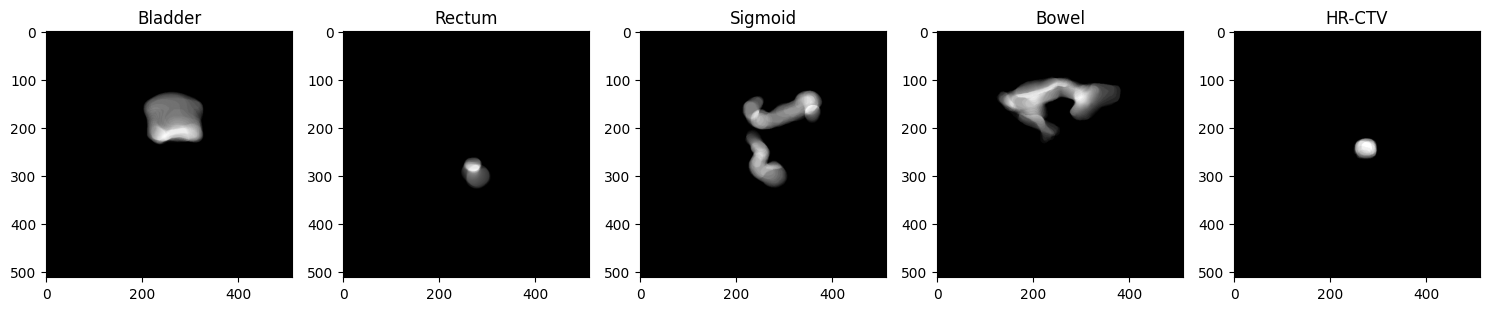

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, num_class, figsize=(3*num_class, 3))

for idx_structure, name_structure in enumerate(structures):
    plt.imshow(np.sum(mask_holder[..., idx_structure], axis=(0)))   

    axes[idx_structure].set_title(name_structure)
    axes[idx_structure].imshow(np.sum(mask_holder[..., idx_structure], axis=(0)), cmap='gray')

plt.tight_layout()
plt.show()